*This notebook can be found on* [github](https://github.com/bastikr/QuantumOptics.jl/blob/master/examples/jaynes-cummings-model.ipynb)

Jaynes-Cummings model
=====================

The [Jaynes Cummings model](https://en.wikipedia.org/wiki/Jaynes%E2%80%93Cummings_model) is a famous theoretical model in the field of quantum optics. It describes a two level atom coupled to a quantized mode of a cavity.

$H = \omega_c a^\dagger a + \frac{\omega_a}{2} \sigma_z + \Omega (a \sigma_+ + a^\dagger \sigma_-)$


The first step is always to import the library

In [1]:
using QuantumOptics
using PyPlot

Then we can define all the necessary parameters

In [2]:
# Parameters
N_cutoff = 10

ωc = 0.1
ωa = 0.1
Ω = 1.;

Describe the Fock Hilbert space and the Spin Hilbert space by choosing the appropriate bases

In [3]:
# Bases
b_fock = FockBasis(N_cutoff)
b_spin = SpinBasis(1//2)
b = b_fock ⊗ b_spin;

With the help of these bases build up the Jaynes-Cummings Hamiltonian

In [4]:
# Fundamental operators
a = destroy(b_fock)
at = create(b_fock)
n = number(b_fock)

sm = sigmam(b_spin)
sp = sigmap(b_spin)
sz = sigmaz(b_spin)

# Hamiltonian
Hatom = ωa*sz/2
Hfield = ωc*n
Hint = Ω*(at⊗sm + a⊗sp)
H = identityoperator(b_fock)⊗Hatom + Hfield⊗identityoperator(b_spin) + Hint;

The time evolution of the system is governed by a Schroedinger equation.

In [5]:
# Initial state
α = 1.
Ψ0 = coherentstate(b_fock, α) ⊗ spindown(b_spin)

# Integration time
T = [0:0.1:20;]

# Schroedinger time evolution
tout, Ψt = timeevolution.schroedinger(T, Ψ0, H);

The integration routine returns two objects - a vector containing points of time where output was generated (which will in most cases be the same as the given input time vector) and a vector containing the state of the quantum system at these points in time. These can further on be used to calculate expectation values.

In [6]:
exp_n = expect(n ⊗ identityoperator(b_spin), Ψt)
exp_sz = expect(identityoperator(b_fock) ⊗ sz, Ψt);

Finally we can us [matplotlib](http://matplotlib.org/) to visualize the the time evolution of the calculated expectation values 

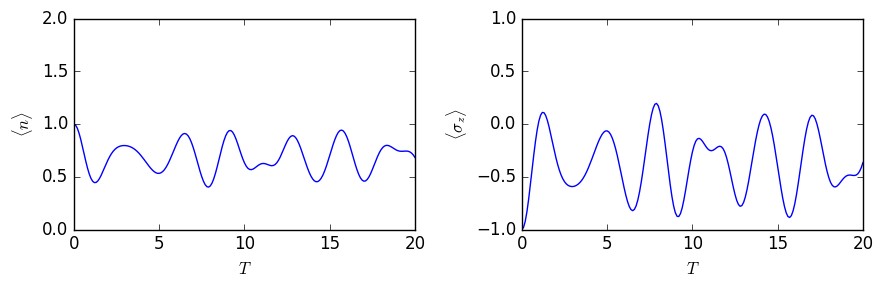

In [7]:
figure(figsize=(9,3))
subplot(1,2,1)
ylim([0, 2])
plot(T, exp_n);
xlabel(L"T")
ylabel(L"\langle n \rangle")

subplot(1,2,2)
ylim([-1, 1])
plot(T, exp_sz);
xlabel(L"T")
ylabel(L"\langle \sigma_z \rangle")

tight_layout();

Lossy Jaynes-Cummings model
---------------------------

The Jaynes-Cummings model can be expanded by giving the 2 level atom a finite spontenous decay rate $\gamma$. The system is then a open quantum system which is described by a master equation of the form

$$
    \dot{\rho} = -\frac{i}{\hbar} \big[H,\rho\big]
                 + \sum_i \big(
                        J_i \rho J_i^\dagger
                        - \frac{1}{2} J_i^\dagger J_i \rho
                        - \frac{1}{2} \rho J_i^\dagger J_i
                    \big)
$$

where in this case there is only one jump operator $J=\sqrt{\gamma} \sigma_-$.

In [8]:
γ = 0.5
J = [sqrt(γ)*identityoperator(b_fock) ⊗ sm];

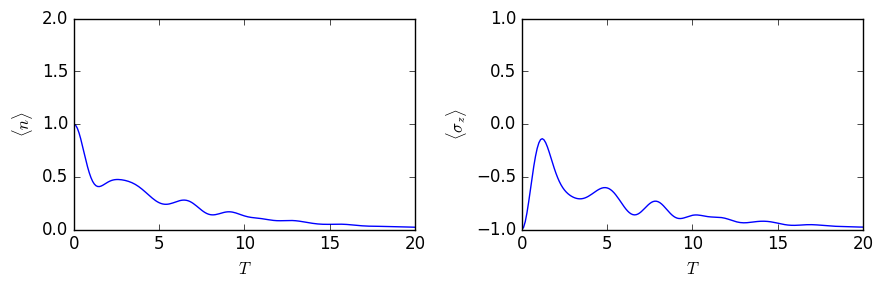

In [9]:
# Master
tout, ρt = timeevolution.master(T, Ψ0, H, J)
exp_n_master = expect(n ⊗ identityoperator(b_spin), ρt)
exp_sz_master = expect(identityoperator(b_fock) ⊗ sz, ρt)

figure(figsize=(9,3))
subplot(1,2,1)
ylim([0, 2])
plot(T, exp_n_master);
xlabel(L"T")
ylabel(L"\langle n \rangle")

subplot(1,2,2)
ylim([-1, 1])
plot(T, exp_sz_master);
xlabel(L"T")
ylabel(L"\langle \sigma_z \rangle");

tight_layout();

Alternatively we can solve the system using the Monte Carlo wave function formalism. A single trajectory shows characteristic jumps in the expectation values.

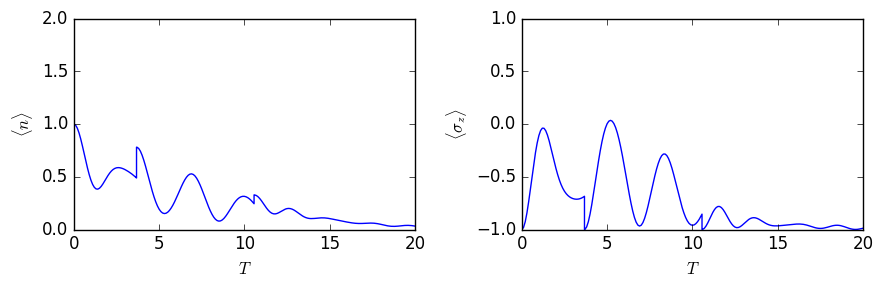

In [10]:
# Monte Carlo wave function
tout, Ψt = timeevolution.mcwf(T, Ψ0, H, J; seed=2,
                                display_beforeevent=true,
                                display_afterevent=true)
exp_n_mcwf = expect(n ⊗ identityoperator(b_spin), Ψt)
exp_sz_mcwf = expect(identityoperator(b_fock) ⊗ sz, Ψt)

figure(figsize=(9,3))
subplot(1,2,1)
ylim([0, 2])
plot(tout, exp_n_mcwf)
xlabel(L"T")
ylabel(L"\langle n \rangle")

subplot(1,2,2)
ylim([-1, 1])
plot(tout, exp_sz_mcwf)
xlabel(L"T")
ylabel(L"\langle \sigma_z \rangle");

tight_layout();

For large number of trajectories the statistical average of the MCWF trajectories approaches the solution of the master equation.

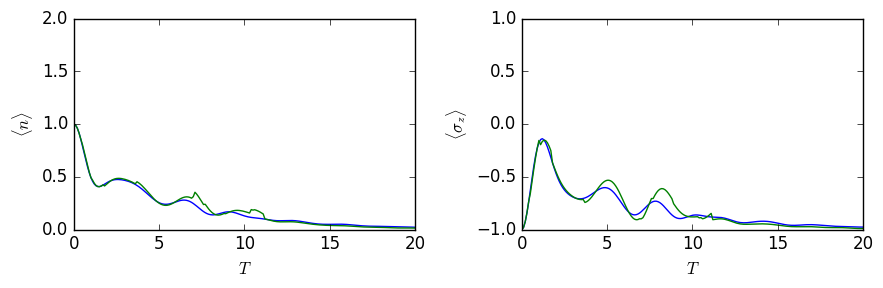

In [11]:
Ntrajectories = 10
exp_n_average = zeros(Float64, length(T))
exp_sz_average = zeros(Float64, length(T))

for i = 1:Ntrajectories
    tout, Ψt = timeevolution.mcwf(T, Ψ0, H, J; seed=i)
    exp_n_average += expect(n ⊗ identityoperator(b_spin), Ψt)
    exp_sz_average += expect(identityoperator(b_fock) ⊗ sz, Ψt)
end

exp_n_average /= Ntrajectories
exp_sz_average /= Ntrajectories

figure(figsize=(9,3))
subplot(1,2,1)
ylim([0, 2])
plot(T, exp_n_master)
plot(T, exp_n_average)
xlabel(L"T")
ylabel(L"\langle n \rangle")

subplot(1,2,2)
ylim([-1, 1])
plot(T, exp_sz_master)
plot(T, exp_sz_average)
xlabel(L"T")
ylabel(L"\langle \sigma_z \rangle");

tight_layout();